In [50]:
import datetime as dt
import yfinance as yf
import pandas as pd

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error


import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler


import pandas
import talib
import pandas_ta as ta

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV

import warnings
from tqdm import tqdm
import time

In [161]:
# Define data range
compagnies = ['MSFT','BAC','JNJ','TSLA','GOOGL']


company = 'TSLA' # 'JNJ'

# start = dt.datetime(2005,1,1)
# end = dt.datetime(2022,1,1)
# interval = "1h"

In [166]:
data = yf.download(company,progress=False)#, start = start, end=end)
print(data.columns)
print(len(data))



Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
3383


In [258]:
# create new features
def add_features(data,rsiperdiode=10,smaperdiode=10,Mfastper=12,Mslowper=26,Msignalper=9,Sfast=5,Sslowk=3,Sslowd=3):
    data['RSI'] = talib.RSI(data['Close'], timeperiod=rsiperdiode)
    data['SMA'] = talib.SMA(data['Close'], timeperiod=smaperdiode)
    data['MACD'], data['Signal'], _ = talib.MACD(data['Close'], fastperiod=Mfastper, slowperiod=Mslowper, signalperiod=Msignalper)
    data['Stochastic'], data['Stochastic_Signal'] = talib.STOCH(data['High'], data['Low'], data['Close'], fastk_period=Sfast, slowk_period=Sslowk, slowd_period=Sslowd)

    
    return data


In [168]:
# élaguage
window_size = 35

data = add_features(data)
features_to_lag= data.columns


features_to_lag = data.columns
lagged_data = pd.concat([data[feature].shift(i) for i in range(1, window_size + 1) for feature in features_to_lag], axis=1)
lagged_data.columns = [f'{feature}_lag_{i}' for i in range(1, window_size + 1) for feature in features_to_lag]

# Drop rows with NaN values created by lagging
lagged_data = lagged_data.dropna(axis=0)

In [169]:
##certainement à modifier dans ce cas la prendre la valeur la plus proche car série temporelle
# data = data.fillna(data.mean())

# supprimer les ligne avec des None ca elles ne sont pas iteressantes
data = data.dropna(axis=0)

In [170]:
print(len(lagged_data),len(data))

3315 3350


In [171]:
target = ["Close","Open","Low","High","Adj Close","Volume"]
y = data[target]
X = lagged_data
print(y.shape,X.shape)
# supprimer les première valeurs
y= y.drop(y.index[:window_size])
print(y.shape,X.shape)

(3350, 6) (3315, 350)
(3315, 6) (3315, 350)


In [172]:
scaler = StandardScaler()
if not data.empty:
    X = scaler.fit_transform(X)



In [173]:
nb_to_predict = 10
X_train = X[:-nb_to_predict]
y_train = y[:-nb_to_predict]
X_val = X[-nb_to_predict:]
y_val = y[-nb_to_predict:]
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)


(3305, 350) (3305, 6) (10, 350) (10, 6)


In [174]:
def compute_metrics(y_pred,y_val):
    mse = mean_squared_error(y_val, y_pred)

    mae = mean_absolute_error(y_val, y_pred)
    return mae,mse

In [326]:
def execute_pipeline(window_size,model,target="Close",company="BAC",nb_to_predict=10,with_added_features=True,rsiperdiode=10,smaperdiode=10,Mfastper=12,Mslowper=26,Msignalper=9,Sfast=5,Sslowk=3,Sslowd=3):
    data = yf.download(company,progress=False)
    if with_added_features:
        data = add_features(data,rsiperdiode,smaperdiode,Mfastper,Mslowper,Msignalper,Sfast,Sslowk,Sslowd)
    features_to_lag = data.columns
    lagged_data = pd.concat([data[feature].shift(i) for i in range(1, window_size + 1) for feature in features_to_lag], axis=1)
    lagged_data.columns = [f'{feature}_lag_{i}' for i in range(1, window_size + 1) for feature in features_to_lag]
            
    lagged_data = lagged_data.dropna(axis=0)
    # pour avoir le même nombre de données
    data = data.dropna(axis=0)
    
    
    
    y = data[[target]]
    X = lagged_data
    # supprimer les première valeurs
    y= y.drop(y.index[:window_size])
    
    scaler = StandardScaler()
    scaler2 = StandardScaler()
    X = scaler.fit_transform(X)
    y = scaler2.fit_transform(y.values.reshape(-1, 1))
    X_train = X[:-nb_to_predict]
    y_train = y[:-nb_to_predict]
    X_val = X[-nb_to_predict:]
    y_val = y[-nb_to_predict:]
    
    
    model.fit(X_train, y_train.ravel())
    
    train_pred_target = model.predict(X_train)
    train_pred_target = scaler2.inverse_transform(train_pred_target.reshape(-1, 1)).flatten()

    train_mae,train_mse = compute_metrics(train_pred_target,scaler2.inverse_transform(y_train.reshape(-1, 1)).flatten())
    
    val_pred_target = model.predict(X_val)
    val_pred_target = scaler2.inverse_transform(val_pred_target.reshape(-1, 1)).flatten()
    
    val_mae,val_mse = compute_metrics(val_pred_target,scaler2.inverse_transform(y_val.reshape(-1, 1)).flatten())
    
    return train_mae,train_mse,val_mae,val_mse
    
    
    
    
    
        
    
    
    
    
    

In [234]:

# définition des modèles d'entrainement
model_list = []

# SVR
svr = SVR(kernel='rbf', C=1.0, gamma='scale')
model_list.append(svr)

# linear regressor
linear =  LinearRegression()
model_list.append(linear)

# RIdge regressor
ridge = Ridge(fit_intercept=False)
model_list.append(ridge)



# KNN
knn = KNeighborsRegressor(n_neighbors=5)
model_list.append(knn)



# Analyse

In [235]:
def window_opti(with_new_features):
    window_size_to_test= [1,5,10,15,20,25,30,35,50,100,150,200,300,500]
    target = "Close"
    train_mae,train_mse,val_mae,val_mse = [],[],[],[]
    execution_time= []
    for window_size in tqdm(window_size_to_test):
        start = time.time()
        train_mae_tmp,train_mse_tmp,val_mae_tmp,val_mse_tmp = execute_pipeline(window_size,model=model_list[2],target=target,company="BAC",nb_to_predict=10,with_added_features=with_new_features)
        end = time.time()
        execution_time.append(end-start)
        train_mae.append(train_mae_tmp)
        train_mse.append(train_mse_tmp)
        val_mae.append(val_mae_tmp)
        val_mse.append(val_mse_tmp)

    plt.plot(window_size_to_test,train_mae,color="blue",marker='*',label="Train mae")
    plt.plot(window_size_to_test,train_mse,color="red",marker='*',label="Train mse")
    plt.plot(window_size_to_test,val_mae,color="green",marker='*',label="Val mae")
    plt.plot(window_size_to_test,val_mse,color="yellow",marker='*',label="Val mse")
    plt.legend()
    plt.title(f"{target} metrics evolution in function of the window size")
    plt.xlabel("Window_size")
    plt.ylabel("Metrics")
    plt.show()

    plt.plot(window_size_to_test,execution_time)
    plt.title(f"Execution time evolution in function of the window size")
    plt.xlabel("Window_size")
    plt.ylabel("execution time")
    plt.show()
    print(f"min mae: {np.min(val_mae)}")
    print(f"min mse: {np.min(val_mse)}")
    print(f"window optimal mae: {window_size_to_test[np.argmin(val_mae)]}")
    print(f"window optimal mse: {window_size_to_test[np.argmin(val_mse)]}")

100%|██████████| 14/14 [00:38<00:00,  2.78s/it]


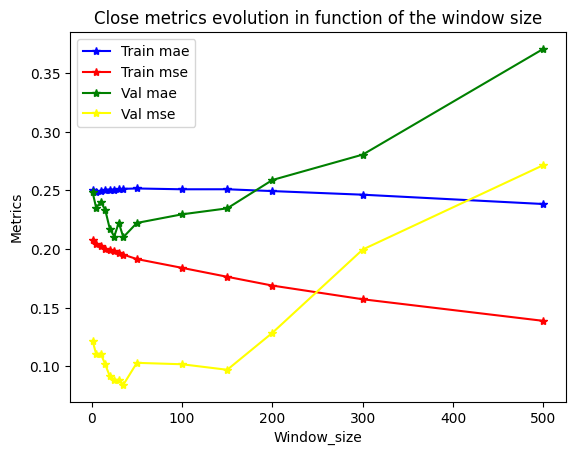

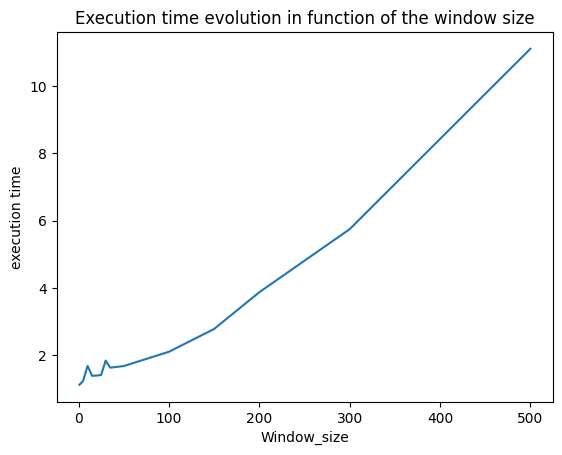

min mae: 0.21014905435073034
min mse: 0.08423713662149032
window optimal mae: 35
window optimal mse: 35


In [236]:
window_opti(with_new_features=True) 

100%|██████████| 14/14 [00:27<00:00,  1.93s/it]


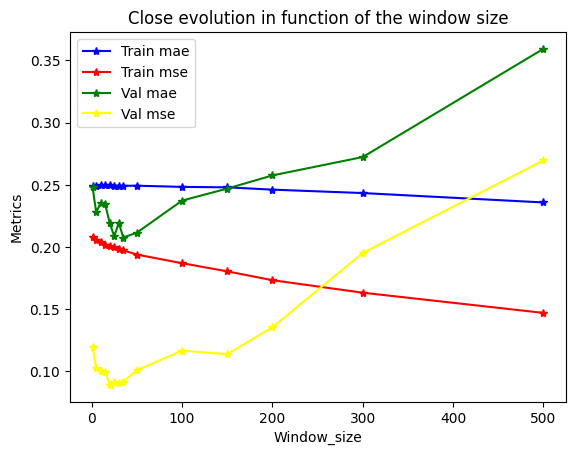

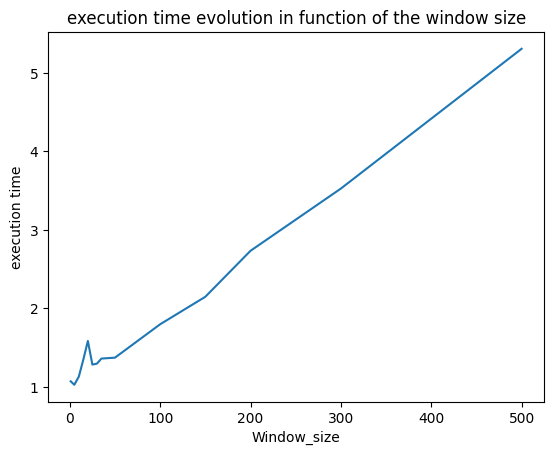

min mae: 0.20755265873324974
min mse: 0.08915364845877029
window optimal mae35
window optimal mse20


In [90]:
window_opti(with_new_features=False)

In [244]:
optimal_window = 35

# Choix du modèle

In [216]:

def model_opti(window_size):
    algos  =["SVR","Linear","Ridge","kNN"]
    target = "Close"
    train_mae,train_mse,val_mae,val_mse = [],[],[],[]
    execution_time= []
    for model in tqdm(model_list):
        start = time.time()
        train_mae_tmp,train_mse_tmp,val_mae_tmp,val_mse_tmp = execute_pipeline(window_size,model,target=target,company="BAC",nb_to_predict=10)
        end = time.time()
        execution_time.append(end-start)
        train_mae.append(train_mae_tmp)
        train_mse.append(train_mse_tmp)
        val_mae.append(val_mae_tmp)
        val_mse.append(val_mse_tmp)

    plt.plot(algos,train_mae,color="blue",marker='*',label="Train mae")
    plt.plot(algos,train_mse,color="red",marker='*',label="Train mse")
    plt.plot(algos,val_mae,color="green",marker='*',label="Val mae")
    plt.plot(algos,val_mse,color="yellow",marker='*',label="Val mse")
    plt.legend()
    plt.title(f"{target} evolution in function of the model type (window size = {window_size})")
    plt.xlabel("Model")
    plt.ylabel("Metrics")
    plt.show()

    plt.plot(algos,execution_time)
    plt.title(f"execution time evolution in function of the model type (window size = {window_size})")
    plt.xlabel("Model")
    plt.ylabel("execution time")
    plt.show()

100%|██████████| 4/4 [00:17<00:00,  4.49s/it]


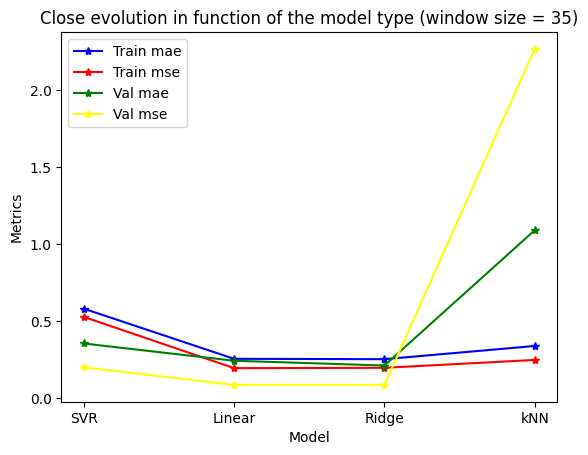

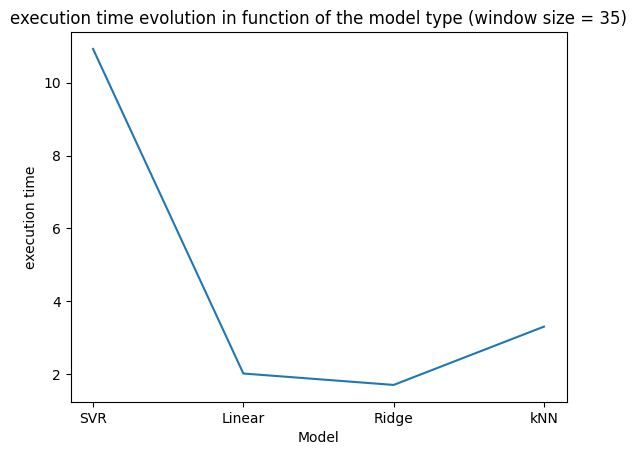

In [203]:
model_opti(35)

100%|██████████| 4/4 [00:31<00:00,  7.95s/it]


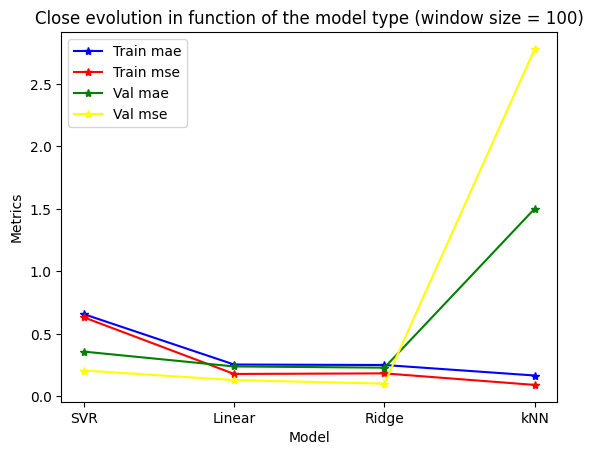

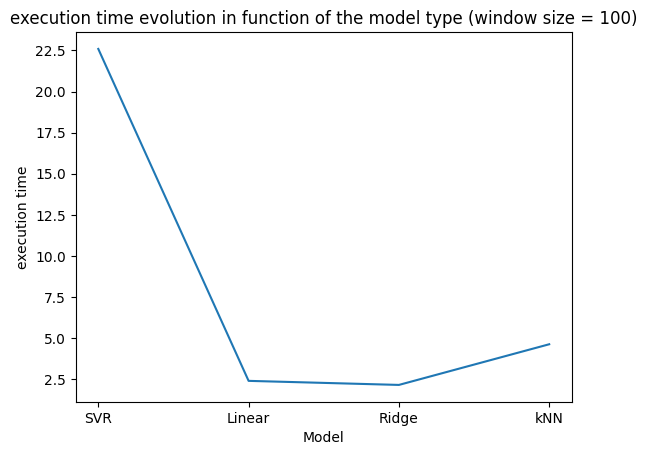

In [204]:
model_opti(100)

100%|██████████| 4/4 [00:08<00:00,  2.18s/it]


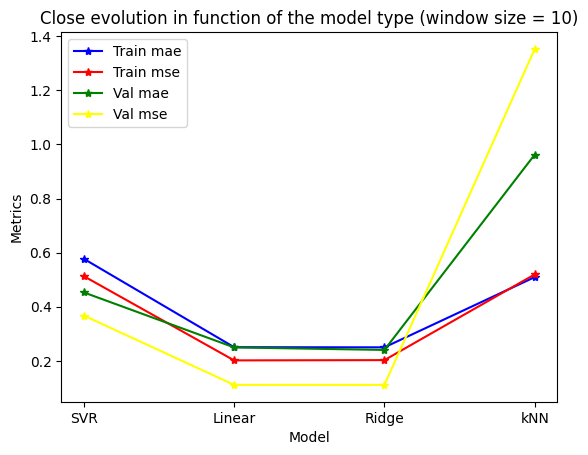

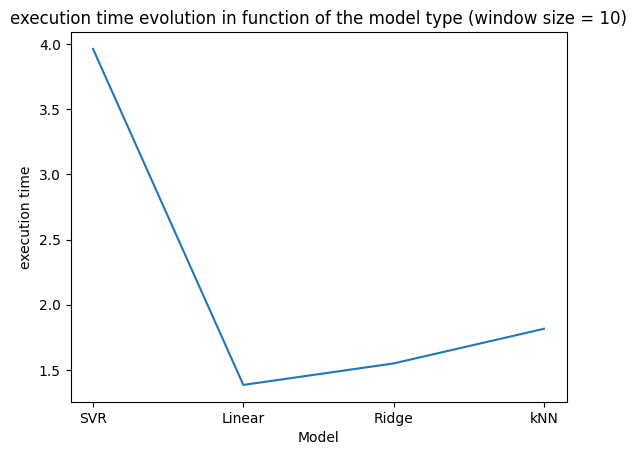

In [205]:
model_opti(10)

100%|██████████| 4/4 [00:12<00:00,  3.16s/it]


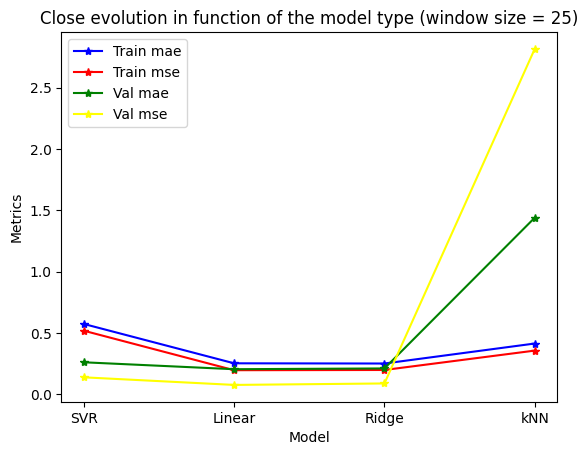

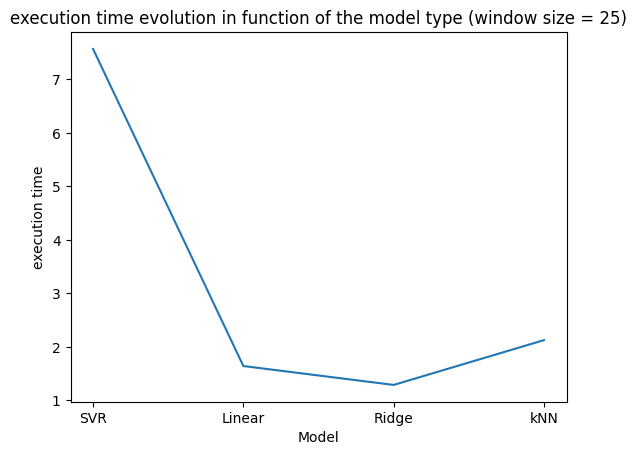

In [206]:
model_opti(25)

100%|██████████| 4/4 [00:13<00:00,  3.45s/it]


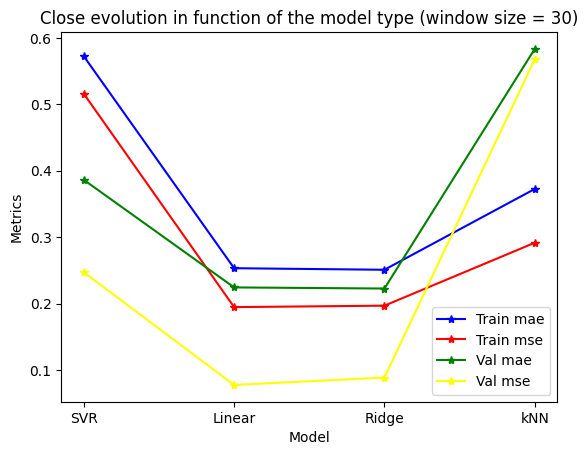

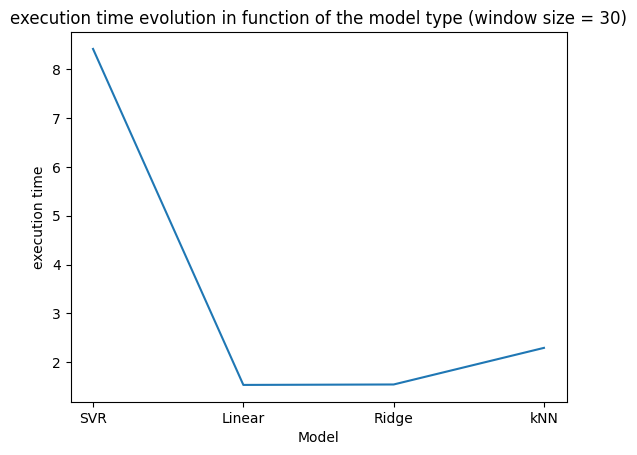

In [207]:
model_opti(30)

On s'aperçoit étonnament que les meilleurs performances sont obtenues avec des regressions linéaires classique alors qu'on aurait pu penser qu'un SVR aurait de meilleur performances

# Optimisation des features générés

In [327]:

def opti_features_mae():
    rsiperdiode = [5,10,15]
    smaperdiode = [5,10,15]
    Mfastper = [8,12,16]
    Mslowper= [20,26,32]
    Msignalper=[6,9,12]
    Sfast = [3,5,7]
    Sslowk= [1,3,5]
    Sslowd= [1,3,5]
    fluctuation = []
    minmse = 100
    for rsiperdiode1 in rsiperdiode:
        for smaperdiode1 in smaperdiode:
            for Mfastper1 in Mfastper:
                for Mslowper1 in Mslowper:
                    for Msignalper1 in Msignalper:
                        for Sfast1 in Sfast:
                            for Sslowk1 in Sslowk:
                                for Sslowd1 in Sslowd:
                                    train_mae_tmp,train_mse_tmp,val_mae_tmp,val_mse_tmp = execute_pipeline(optimal_window,model_list[2],target="Close",company="BAC",nb_to_predict=10,with_added_features=True,rsiperdiode=rsiperdiode1,smaperdiode=smaperdiode1,Mfastper=Mfastper1,Mslowper=Mslowper1,Msignalper=Msignalper1,Sfast=Sfast1,Sslowk=Sslowk1,Sslowd=Sslowd1)
                                    fluctuation.append(val_mse_tmp)
                                    if val_mse_tmp < minmse:
                                        minmse = val_mse_tmp
                                        best_param = [rsiperdiode1,smaperdiode1,Mfastper1,Mslowper1,Msignalper1,Sfast1,Sslowk1,Sslowd1]
    return minmse,best_param,fluctuation
                                    
                                    
        
    

In [328]:
minmse,best_param ,fluctuation= opti_features_mae()

meilleur mae: 0.08072443892669216,meilleurs paramètres: [[5, 10, 15], [5, 10, 15], [8, 12, 16], [20, 26, 32], [6, 9, 12], [3, 5, 7], [1, 3, 5], [1, 3, 5]]


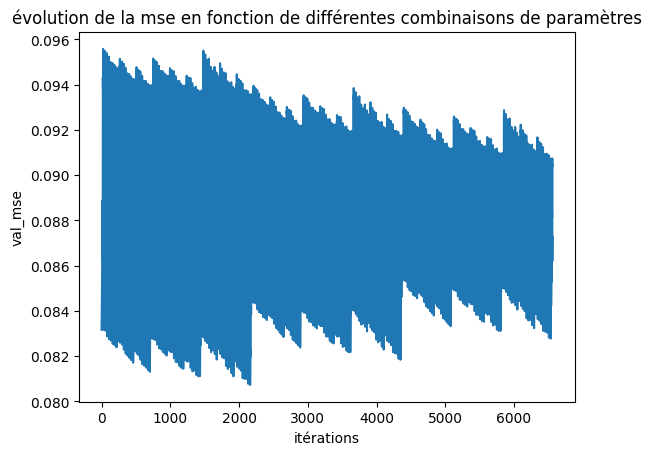

In [ ]:
print(f"meilleur mae: {minmse},meilleurs paramètres: {best_param}")
plt.plot(fluctuation)
plt.xlabel("itérations")
plt.ylabel("val_mse")
plt.title("évolution de la mse en fonction de différentes combinaisons de paramètres")
plt.show()

# Optimisation du modèle

In [253]:
def optimise_pipeline_with_lasso(window_size, target="Close", company="BAC", nb_to_predict=10, with_added_features=True):
    data = yf.download(company, progress=False)
    
    if with_added_features:
        data = add_features(data)
    
    features_to_lag = data.columns
    lagged_data = pd.concat([data[feature].shift(i) for i in range(1, window_size + 1) for feature in features_to_lag], axis=1)
    lagged_data.columns = [f'{feature}_lag_{i}' for i in range(1, window_size + 1) for feature in features_to_lag]
            
    lagged_data = lagged_data.dropna(axis=0)
    data = data.dropna(axis=0)
    
    y = data[[target]]
    X = lagged_data
    y = y.drop(y.index[:window_size])
    
    scaler = StandardScaler()
    scaler2 = StandardScaler()
    X = scaler.fit_transform(X)
    y = scaler2.fit_transform(y.values.reshape(-1, 1))
    X_train = X[:-nb_to_predict]
    y_train = y[:-nb_to_predict]
    X_val = X[-nb_to_predict:]
    y_val = y[-nb_to_predict:]

    ridge_model = Ridge()
    
    param_grid = {'alpha': [0.01, 0.1, 1, 10, 100],
                  'fit_intercept': [True,False],
                  'copy_X': [True,False]
                  }  

    grid_search = GridSearchCV(ridge_model, param_grid, scoring='neg_mean_squared_error', cv=10)
    
    grid_search.fit(X_train, y_train.ravel())

    best_lasso_model = grid_search.best_estimator_

    train_pred_target = best_lasso_model.predict(X_train)
    train_pred_target = scaler2.inverse_transform(train_pred_target.reshape(-1, 1)).flatten()
    train_mae, train_mse = compute_metrics(train_pred_target, scaler2.inverse_transform(y_train.reshape(-1, 1)).flatten())

    val_pred_target = best_lasso_model.predict(X_val)
    val_pred_target = scaler2.inverse_transform(val_pred_target.reshape(-1, 1)).flatten()
    val_mae, val_mse = compute_metrics(val_pred_target, scaler2.inverse_transform(y_val.reshape(-1, 1)).flatten())
    print("train mae:",train_mae,"train mse:", train_mse,"val mae:", val_mae,"val mse:", val_mse )
    return grid_search

In [245]:
grid_search = optimise_pipeline_with_lasso(optimal_window)
print("Best Parameters:", grid_search.best_params_)

train mae: 0.25537685673604515 train mse: 0.20403933659995743 val mae: 0.21863106508636926 val mse: 0.09300527580457149
Best Parameters: {'alpha': 10, 'copy_X': True, 'fit_intercept': False}


# Results

In [254]:
def res(window_size=35,model=model_list[2],company="BAC",nb_to_predict=100,with_added_features=True,rsiperdiode=10,smaperdiode=10,Mfastper=12,Mslowper=26,Msignalper=9,Sfast=5,Sslowk=3,Sslowd=3):
    target = ["Close","Open","Low","High","Adj Close","Volume"]
    for targ in target:
        data = yf.download(company,progress=False)
        if with_added_features:
            data = add_features(data,rsiperdiode,smaperdiode,Mfastper,Mslowper,Msignalper,Sfast,Sslowk,Sslowd)
        features_to_lag = data.columns
        lagged_data = pd.concat([data[feature].shift(i) for i in range(1, window_size + 1) for feature in features_to_lag], axis=1)
        lagged_data.columns = [f'{feature}_lag_{i}' for i in range(1, window_size + 1) for feature in features_to_lag]
                
        lagged_data = lagged_data.dropna(axis=0)
        # pour avoir le même nombre de données
        data = data.dropna(axis=0)
        
        
        
        y = data[[targ]]
        X = lagged_data
        # supprimer les première valeurs
        y= y.drop(y.index[:window_size])
        
        scaler = StandardScaler()
        scaler2 = StandardScaler()
        X = scaler.fit_transform(X)
        y = scaler2.fit_transform(y.values.reshape(-1, 1))
        X_train = X[:-nb_to_predict]
        y_train = y[:-nb_to_predict]
        X_val = X[-nb_to_predict:]
        y_val = y[-nb_to_predict:]
        
        
        model.fit(X_train, y_train.ravel())
        
        train_pred_target = model.predict(X_train)
        train_pred_target = scaler2.inverse_transform(train_pred_target.reshape(-1, 1)).flatten()

        train_mae,train_mse = compute_metrics(train_pred_target,scaler2.inverse_transform(y_train.reshape(-1, 1)).flatten())
        print(f"Training : mae :{train_mae} , mse:{train_mse}")
        
        plt.subplot(1,2,1)
        plt.plot(range(y_train.shape[0]), train_pred_target, color='blue', label='Predicted')
        plt.plot(range(y_train.shape[0]), scaler2.inverse_transform(y_train.reshape(-1, 1)).flatten(), color='red', label='Actual')
        plt.title(f'Train Data {targ} {company}')
        plt.legend()
        
        val_pred_target = model.predict(X_val)
        val_pred_target = scaler2.inverse_transform(val_pred_target.reshape(-1, 1)).flatten()
        
        val_mae,val_mse = compute_metrics(val_pred_target,scaler2.inverse_transform(y_val.reshape(-1, 1)).flatten())
        
        print(f"Validation: mae :{val_mae} , mse:{val_mse}")
        plt.subplot(1,2,2)
        plt.plot(range(y_val.shape[0]), val_pred_target, color='blue', label='Predicted')
        plt.plot(range(y_val.shape[0]), scaler2.inverse_transform(y_val.reshape(-1, 1)).flatten(), color='red', label='Actual')
        plt.title(f'Val Data {targ} {company}')
        plt.legend()
        plt.show()
        
        
        


        
        
        
        
        
        
        

Training : mae :1.9025207824281638 , mse:17.426268311356626
Validation: mae :5.840961212190293 , mse:60.6135901952528


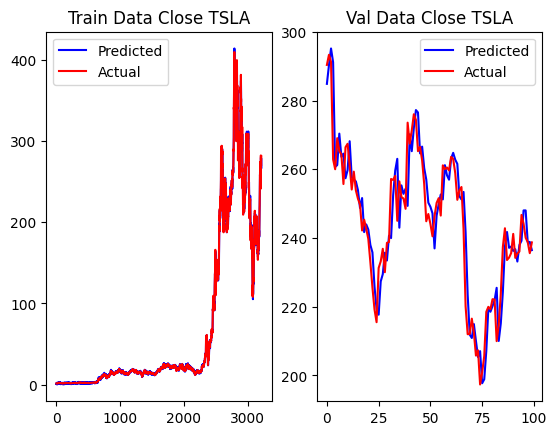

Training : mae :1.0452783847300702 , mse:5.393108439957118
Validation: mae :3.018098206082785 , mse:17.48371717051526


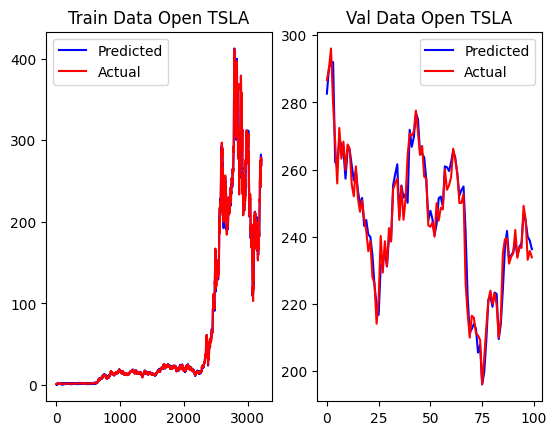

Training : mae :1.4654373064412365 , mse:10.038748880031552
Validation: mae :3.9879766724220906 , mse:32.506874404387375


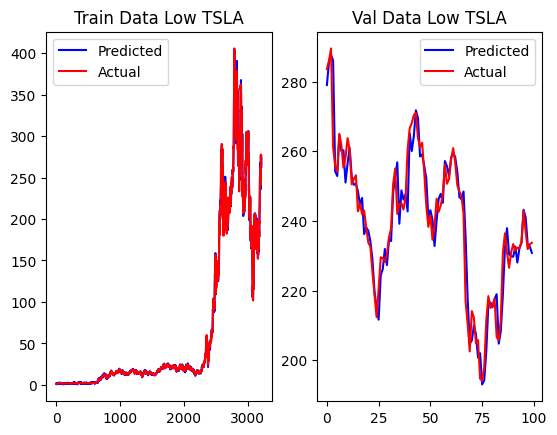

Training : mae :1.3798690264311955 , mse:8.93989919945949
Validation: mae :4.273705248474447 , mse:30.20416732913876


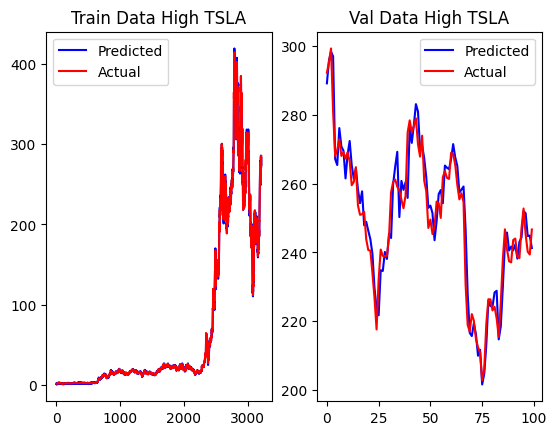

Training : mae :1.9025207824281638 , mse:17.426268311356626
Validation: mae :5.840961212190293 , mse:60.6135901952528


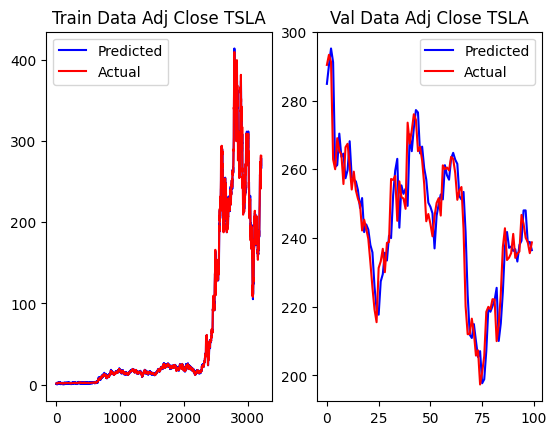

Training : mae :27060570.85226359 , mse:2055566121979766.5
Validation: mae :14199131.4698583 , mse:344065657654132.75


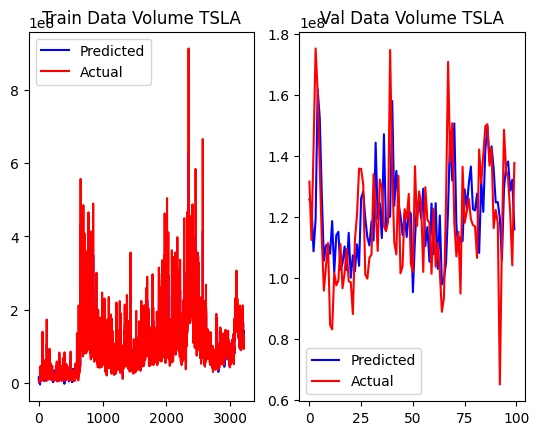

In [256]:
res(company="TSLA")

Training : mae :0.5130827577966119 , mse:0.9488837946675481
Validation: mae :1.6042028884605137 , mse:5.123387059019734


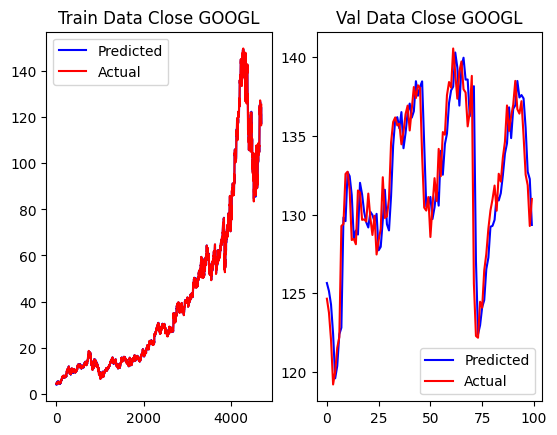

Training : mae :0.2825089319176595 , mse:0.3867879572328419
Validation: mae :0.9505334166746436 , mse:2.6486732513123297


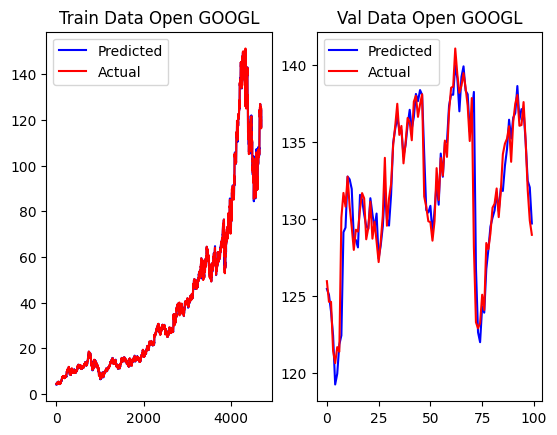

Training : mae :0.39887547891062414 , mse:0.6001768607111095
Validation: mae :1.2756454477548278 , mse:3.798253721211917


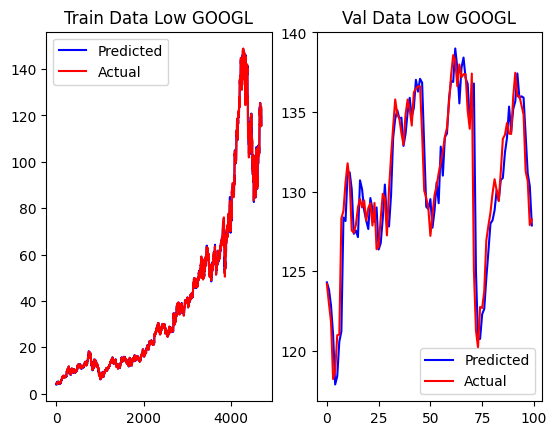

Training : mae :0.37395314707130695 , mse:0.5738464707884875
Validation: mae :1.2271621563055775 , mse:3.6167444524236014


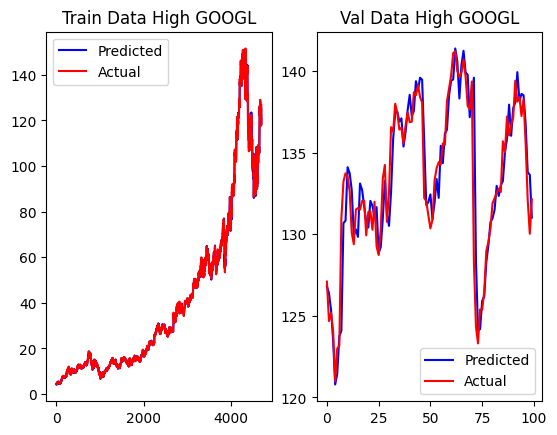

Training : mae :0.5130827577966119 , mse:0.9488837946675481
Validation: mae :1.6042028884605137 , mse:5.123387059019734


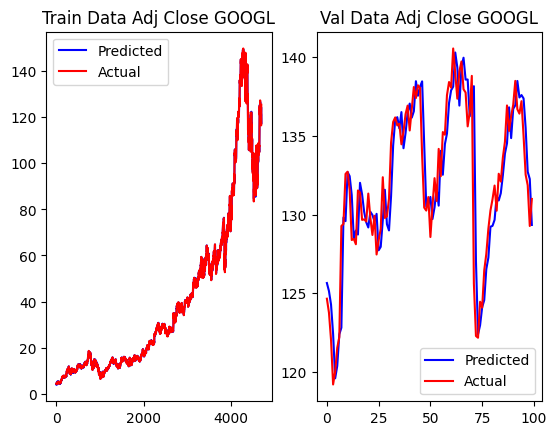

Training : mae :33145836.788654294 , mse:4855127535682204.0
Validation: mae :8616529.441661555 , mse:144966284507966.06


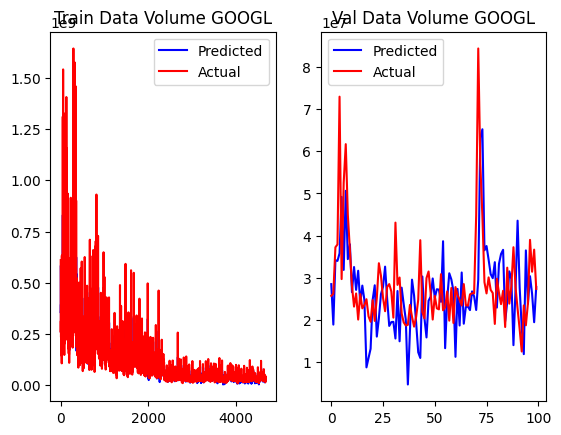

In [257]:
res(company="GOOGL")

# Analyse sur une durée plus longue sans avoir accès aux données

In [295]:
def execute_pipeline_long(window_size,model,target=["Close","Open","Low","High","Adj Close","Volume"],company="BAC",nb_to_predict=10,with_added_features=True,rsiperdiode=10,smaperdiode=10,Mfastper=12,Mslowper=26,Msignalper=9,Sfast=5,Sslowk=3,Sslowd=3):
    res = {"Close":[],
           "Open":[],
           "Low":[],
           "High":[],
           "Adj Close":[],
           "Volume":[]}
    data_tmp = pd.DataFrame()
    for jour in range(1,nb_to_predict+1):
        data = yf.download(company,progress=False)
        # on supprime les valeurs qui n'hexite pas encore
        data= data.drop(data.index[-nb_to_predict+1:])
        data =pd.concat([data,data_tmp])
        if with_added_features:
            data = add_features(data,rsiperdiode,smaperdiode,Mfastper,Mslowper,Msignalper,Sfast,Sslowk,Sslowd)
        features_to_lag = data.columns
        lagged_data = pd.concat([data[feature].shift(i) for i in range(1, window_size + 1) for feature in features_to_lag], axis=1)
        lagged_data.columns = [f'{feature}_lag_{i}' for i in range(1, window_size + 1) for feature in features_to_lag]         
        lagged_data = lagged_data.dropna(axis=0)
        # pour avoir le même nombre de données
        data = data.dropna(axis=0)
        X = lagged_data
        data_tmp = pd.DataFrame()
        for targ in target:
            
            y = data[[targ]]
            # supprimer les première valeurs
            y= y.drop(y.index[:window_size])
           
            
            scaler = StandardScaler()
            scaler2 = StandardScaler()
            X = scaler.fit_transform(X)
            y = scaler2.fit_transform(y.values.reshape(-1, 1))
            X_train = X[:-jour]
            y_train = y[:-jour]
            X_val = X[-1:]
            y_val = y[-1:]
            
            
            model.fit(X_train, y_train.ravel())
            
            
            val_pred_target = model.predict(X_val)
            val_pred_target = scaler2.inverse_transform(val_pred_target.reshape(-1, 1)).flatten()
            
            res[targ].append(val_pred_target[0])
            # print(f"target: {targ}, value: {val_pred_target[0]} validation mae: {val_mae}, validation mse: {val_mse}")
            data_tmp[targ]= val_pred_target
    return res
        

In [302]:
res_pred=execute_pipeline_long(35,model_list[2])


In [304]:
def restr(window_size=35,model=model_list[2],company="BAC",nb_to_predict=10,with_added_features=True,rsiperdiode=10,smaperdiode=10,Mfastper=12,Mslowper=26,Msignalper=9,Sfast=5,Sslowk=3,Sslowd=3):
    target = ["Close","Open","Low","High","Adj Close","Volume"]
    res = {"Close":[],
           "Open":[],
           "Low":[],
           "High":[],
           "Adj Close":[],
           "Volume":[]}
    for targ in target:
        data = yf.download(company,progress=False)
        if with_added_features:
            data = add_features(data,rsiperdiode,smaperdiode,Mfastper,Mslowper,Msignalper,Sfast,Sslowk,Sslowd)
        features_to_lag = data.columns
        lagged_data = pd.concat([data[feature].shift(i) for i in range(1, window_size + 1) for feature in features_to_lag], axis=1)
        lagged_data.columns = [f'{feature}_lag_{i}' for i in range(1, window_size + 1) for feature in features_to_lag]
                
        lagged_data = lagged_data.dropna(axis=0)
        # pour avoir le même nombre de données
        data = data.dropna(axis=0)
        
        
        
        y = data[[targ]]
        X = lagged_data
        # supprimer les première valeurs
        y= y.drop(y.index[:window_size])
        
        scaler = StandardScaler()
        scaler2 = StandardScaler()
        X = scaler.fit_transform(X)
        y = scaler2.fit_transform(y.values.reshape(-1, 1))
        X_train = X[:-nb_to_predict]
        y_train = y[:-nb_to_predict]
        X_val = X[-nb_to_predict:]
        y_val = y[-nb_to_predict:]
        res[targ]= scaler2.inverse_transform(y_val.reshape(-1, 1)).flatten()
    return res
        
        
        
        
        
        
        
        

In [305]:
restrue= restr()

In [306]:
print(len(res_pred["Close"]))
print(len(restrue["Close"]))

10
10


In [321]:
def plot_res(compagny,window_size=optimal_window,nb_to_predict=10):
    res_pred=execute_pipeline_long(window_size,model_list[2],company=compagny,nb_to_predict=nb_to_predict)
    res_true= restr(company=compagny,nb_to_predict=nb_to_predict)

    
    for target in restrue.keys():
        plt.plot(range(len(res_pred[target])), res_pred[target], color='blue', label='Predicted')
        plt.plot(range(len(res_pred[target])), res_true[target], color='red', label='Actual')
        plt.title(f'Val Data {target} {compagny}, {len(res_pred[target])} days predictions')
        plt.legend()
        plt.show()
    

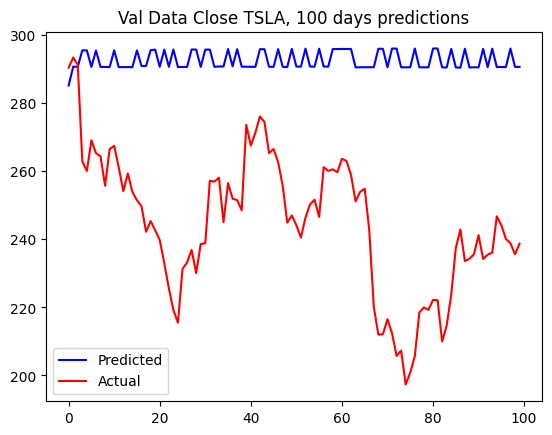

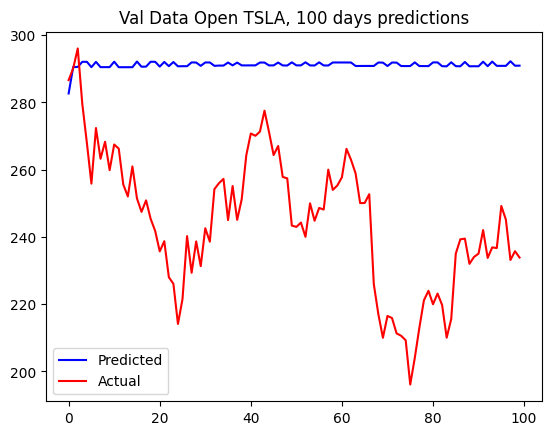

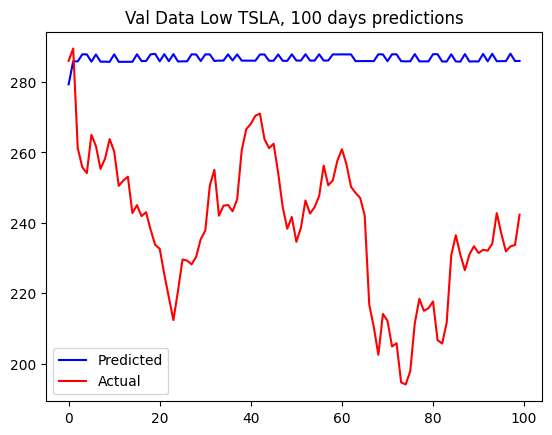

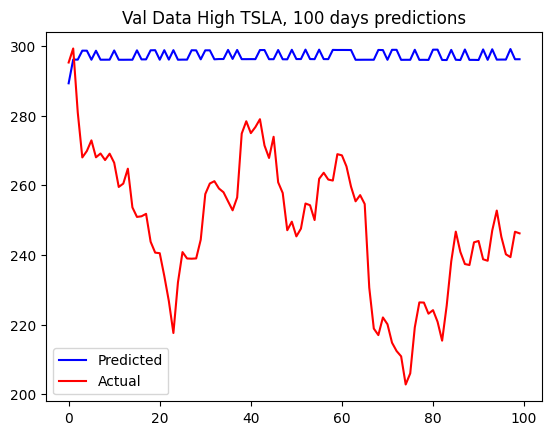

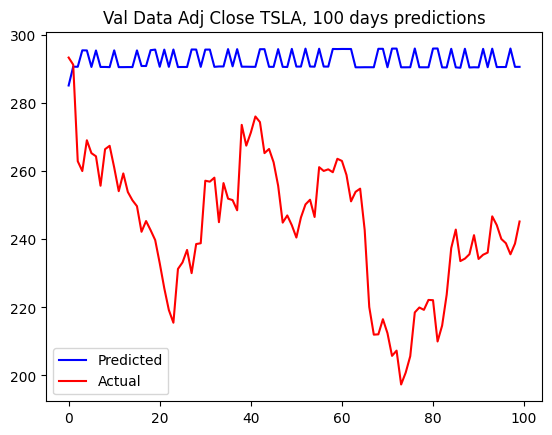

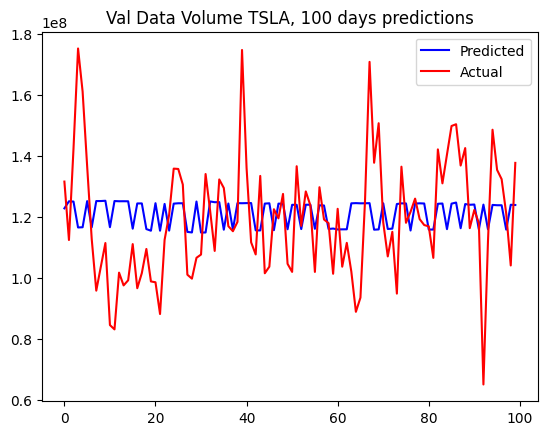

In [322]:
plot_res("TSLA",nb_to_predict=100)

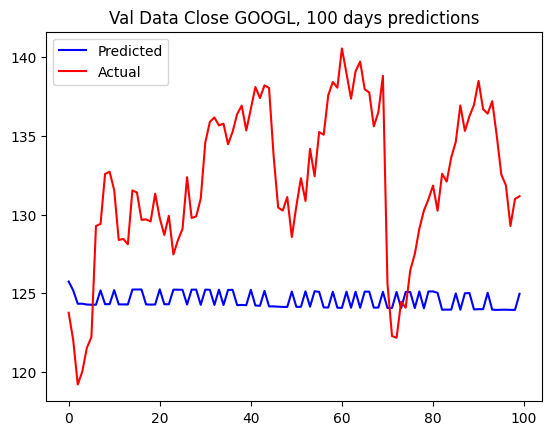

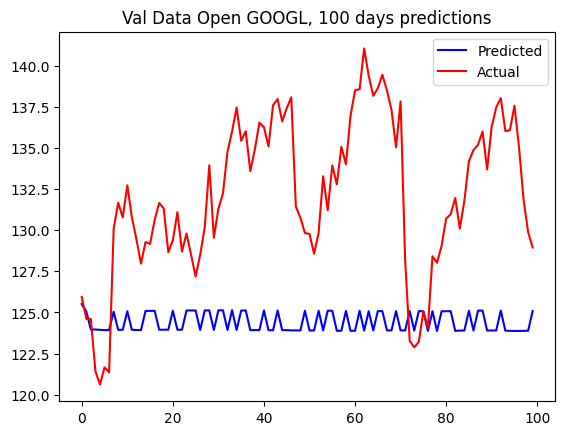

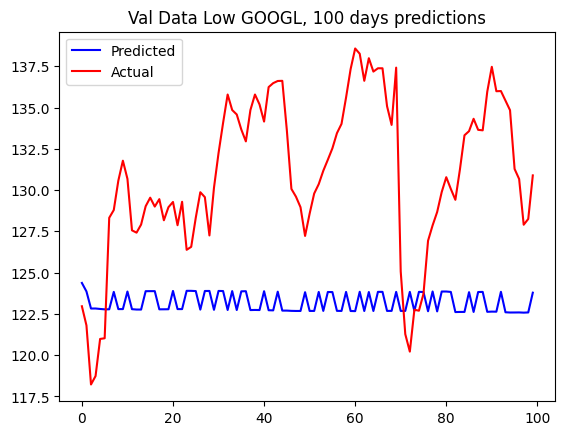

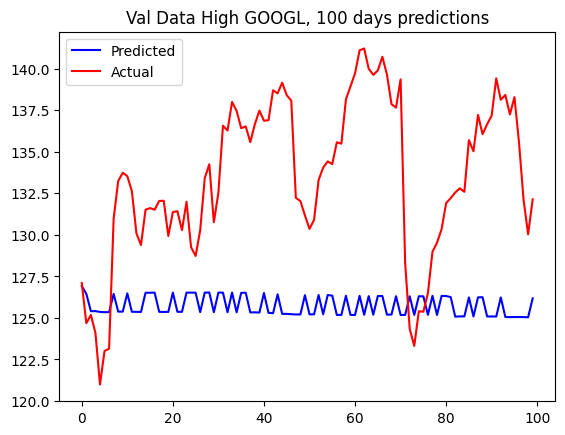

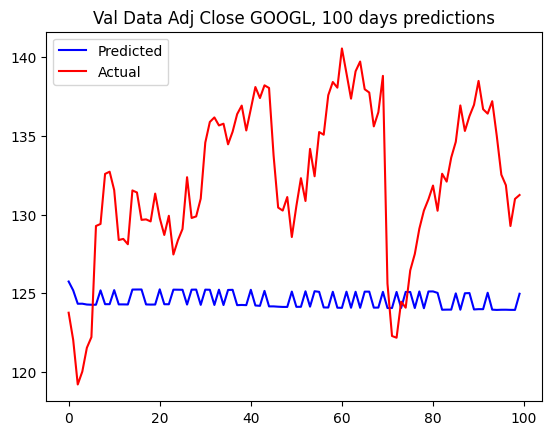

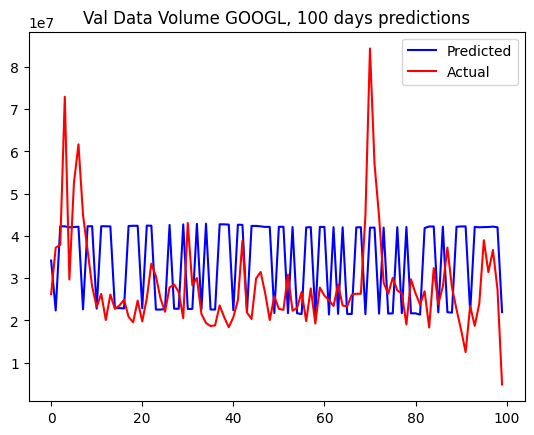

In [323]:
plot_res("GOOGL",nb_to_predict=100)